In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
%matplotlib inline

In [3]:
import json

import akshare as ak
import requests

In [30]:
# USE_CUDA = torch.cuda.is_available()
USE_CUDA = True
BATCH_SIZE = 1
EMBEDDING_SIZE = 650
device = torch.device("cuda" if USE_CUDA else "cpu")

In [31]:
def stock_zh_a_minute(symbol: str = "sz000613", period: str = "5", adjust: str = ""):
    """
    股票及股票指数历史行情数据-分钟数据
    http://finance.sina.com.cn/realstock/company/sh600519/nc.shtml
    :param symbol: sh000300
    :type symbol: str
    :param period: 1, 5, 15, 30, 60 分钟的数据
    :type period: str
    :param adjust: 默认为空: 返回不复权的数据; qfq: 返回前复权后的数据; hfq: 返回后复权后的数据;
    :type adjust: str
    :return: specific data
    :rtype: pandas.DataFrame
    """
    url = (
        "https://quotes.sina.cn/cn/api/jsonp_v2.php/=/CN_MarketDataService.getKLineData"
    )
    params = {
        "symbol": symbol,
        "scale": period,
        "datalen": "10000",
    }
    r = requests.get(url, params=params)
    temp_df = pd.DataFrame(json.loads(r.text.split("=(")[1].split(");")[0])).iloc[:, :6]
    if adjust == "":
        return temp_df

In [32]:
stock_data = stock_zh_a_minute(period="1")

In [33]:
data = torch.Tensor([float(i) for i in stock_data["close"]]).to(device)

In [34]:
trainlen = int(0.7 * len(data))
train = data[:trainlen]
test = data[trainlen:]

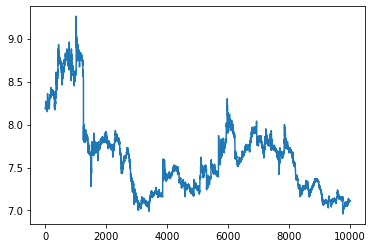

In [56]:
plt.plot(data.cpu())

In [35]:
class RNNModel(nn.Module):
    def __init__(self, rnn_type, nvocab, ninp, nhid, nlayers, dropout=0.5):
        super().__init__()
        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Linear(nvocab, ninp)

        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(ninp, nhid, nlayers, dropout=dropout, batch_first=True)
        elif rnn_type in ["RNN_TANH", "RNN_RELU"]:
            nonlinearity = {"RNN_TANH": "tanh", "RNN_RELU": "relu"}[rnn_type]
            self.rnn = nn.RNN(
                ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout
            )
        else:
            raise ValueError(
                "rnn_type should be in ['LSTM', 'GRU', 'RNN_TANH', RNN_RELU']"
            )

        self.decoder = nn.Linear(nhid, nvocab)
        self.init_weight()

    def init_weight(self):
        init_range = 0.1
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def init_hidden(self, bsz, requires_grad=True):
        weight = next(self.parameters())
        if self.rnn_type == "LSTM":
            return (
                weight.new_zeros(
                    (self.nlayers, bsz, self.nhid), requires_grad=requires_grad
                ),
                weight.new_zeros(
                    (self.nlayers, bsz, self.nhid), requires_grad=requires_grad
                ),
            )
        else:
            return weight.new_zeros(
                (self.nlayers, bsz, self.nhid), requires_grad=requires_grad
            )

    def forward(self, x, hidden):
        # encoder
        x = self.drop(self.encoder(x))
#         # rnn
        x, hidden = self.rnn(x, hidden)
#         # decoder
        x = self.decoder(x)

        return x, hidden

In [36]:
def hidden_detach(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return [hidden_detach(v) for v in h]

In [37]:
# def evaluate(model, data, batch_size, loss_fn):
#     model.eval()
#     total_loss = 0
#     total_cnt = 0
#     it = iter(data)
#     with torch.no_grad():
#         hidden = model.init_hidden(batch_size, requires_grad=False)
#         for i, batch in enumerate(it):
#             text, target = batch.text.to(device), batch.target.to(device)

#             output, hidden = model(text, hidden)

#             loss = loss_fn(output, target)
#             total_cnt += np.multiply(*text.size())
#             total_loss += loss.item() * np.multiply(*text.size())

#     loss = total_loss / total_cnt
#     model.train()
#     return loss

In [38]:
RNN_TYPE = "GRU"

In [39]:
model = RNNModel(RNN_TYPE, 1, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, dropout=0.5)
model = model.to(device)

In [50]:
loss_fn = lambda x,y: nn.MSELoss()(x,y) * 10000
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)

In [41]:
torch.autograd.set_detect_anomaly(True)

In [56]:
PATH = f"./saved_model/{RNN_TYPE}_stock.pth"
if os.path.exists(PATH):
    model.load_state_dict(torch.load(PATH))

GRAD_CLIP = 1.0
EPOCH = 20

mini_loss = float("inf")

for epoch in range(EPOCH):
    model.train()
    hidden = model.init_hidden(BATCH_SIZE)
    i=0
    total=0
    for text, target in zip(train[1:], train[:-1]):
        i+=1
        hidden = hidden_detach(hidden)
        text = text.unsqueeze(0).unsqueeze(0).unsqueeze(0)
        target = target.unsqueeze(0).unsqueeze(0).unsqueeze(0)

        model.zero_grad()
        output, hidden = model(text, hidden)
        loss = loss_fn(output, target)
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        if i%1000 == 0:
            print(i, loss.item())
        total+=loss.item()
    print("epoch", epoch, total/i)
    torch.save(model.state_dict(), PATH)

1000 2.0734643936157227
2000 106.97525024414062
3000 22.929676055908203
4000 419.2766418457031
5000 77.46402740478516
6000 12.793862342834473
epoch 0 127.98829214954817
1000 77.59669494628906
2000 19.488746643066406
3000 116.94258117675781
4000 1.2375696897506714
5000 203.593994140625
6000 4.25592041015625
epoch 1 117.81140583807509
1000 61.76899719238281
2000 65.93382263183594
3000 0.2304306924343109
4000 541.1417236328125
5000 394.1556396484375
6000 774.7254638671875
epoch 2 132.0870602567432
1000 35.17671203613281
2000 5.309650421142578
3000 65.94002532958984
4000 102.13298797607422
5000 18.927846908569336
6000 120.16565704345703
epoch 3 115.89905030889048
1000 372.75079345703125
2000 266.5117492675781
3000 10.250420570373535
4000 11.708600997924805
5000 43.908748626708984
6000 8.887469291687012
epoch 4 112.2480805305422
1000 0.8768689632415771
2000 2.198615312576294
3000 5.733104228973389
4000 28.013700485229492
5000 33.225982666015625
6000 90.36650848388672
epoch 5 119.98498642739

In [46]:
nn.MSELoss()(train[1:], train[:-1])*10000

tensor(5.4978, device='cuda:0')

In [44]:
best_model = RNNModel(RNN_TYPE, 1, EMBEDDING_SIZE, EMBEDDING_SIZE, 2, dropout=0.5)
best_model = best_model.to(device)
best_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [72]:
model.eval()
i=0
total=0
with torch.no_grad():
    for text, target in zip(test[1:], test[:-1]):
        i+=1
        hidden = hidden_detach(hidden)
        text = text.unsqueeze(0).unsqueeze(0).unsqueeze(0)
        target = target.unsqueeze(0).unsqueeze(0).unsqueeze(0)

        model.zero_grad()
        output, hidden = model(text, hidden)
        loss = loss_fn(output, target)
        if i%1000 == 0:
            print(i, loss.item())
        total+=loss.item()
    print("test err", total/i)

1000 358.002197265625
2000 3354.90087890625
test err 2895.474347177594


In [67]:
nn.MSELoss()(test[1:], test[:-1])*10000

tensor(1.9233, device='cuda:0')

In [73]:
# loss 降不下来！！！！！